# Тестовое задание G5
## Описание
Описание конкурса
В исходном датасете есть данные о телесмотрении 3244 пользователей и их характеристиках: "Размер ДХ", "Тип ресивера", "Федеральный округ", "Тип нас.пункта", "Почтовый индекс". Из предоставленных данных можно извлечь дополнительные параметры, если поразмышлять.

Задача восстановить характеристики "Оператор", "Есть ли Интернет", "Состав ДХ" в тренировочных данных.

Первый этап. Необходимо, при помощи обученной модели восстановить недостающие параметры, рассчитать метрики и загрузить итоговый результат в Kagglе для сравнения с настоящими данными (невидимы пользователю) и отображении в таблице лидеров. Мы предполагаем, что значения метрик: Accuarcy, F1 Score выше 80%, и Cohen's Kappa не ниже 70%. Постарайтесь вывести значение Accuracy под каждый параметр в пункте "Метрики". В Notebook необходимо разбить тренировочные данные в соотношение 85/15 для получения значения метрик, после обучить модель на всех тренировочных данных.

Второй этап. Вам необходимо продемонстрировать свое решение (Notebook или WorkFlow в KNIME, итд.) и результаты (my_solution.csv) для того, чтобы мы могли убедиться в чистоте работы с данными и проанализировать ход мыслей. Решение отправляйте на email.
## Решение

### 0. импорт библиотек

In [1]:
import pandas as pd
from sklearn.feature_selection import RFECV
from boruta import BorutaPy
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
import os, re, sys, gc, pickle, time
from collections import defaultdict
from sklearn.metrics import make_scorer, roc_auc_score
import pandas as pd
import numpy as np
from itertools import combinations
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from plot_metric.functions import BinaryClassification
import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
import os, re, sys, gc, pickle, time
from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats
from sklearn.model_selection import GridSearchCV, cross_val_score,\
                                    KFold, train_test_split, cross_validate, ParameterGrid,\
                                    cross_validate, cross_val_predict, TimeSeriesSplit, StratifiedKFold
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin,  clone
from sklearn.metrics import confusion_matrix
# пайплайн
from sklearn.pipeline import Pipeline, make_union, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin,  clone
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
# дамми-регрессор
from sklearn.dummy import DummyClassifier
from itertools import combinations
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve
import shutil
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
import shap

### 0. вспомогательные функции
* представлено 2 класса, с помощью которых производитя отбор признаков
* алгоритм отбора - forward selection
* для логистической регрессии оцениваются значимости к-ов и исключается мультиколлинеарность

In [2]:
class SklearnHelperVIF(BaseEstimator, TransformerMixin):
    ''' Отбор признаков '''
    def __init__(self, treshold):
        self.treshold= treshold
    def fit(self, X, y=None):
        _X = pd.DataFrame(X)
        vif = pd.DataFrame()
        vif["variables"] = _X.columns
        vif["VIF"] = [variance_inflation_factor(_X.values, i) for i in tqdm_notebook(range(_X.shape[1]))]
        self.to_use = vif[vif["VIF"]<=self.treshold]['variables']
        return self
    def transform(self,X):
        _X = pd.DataFrame(X)
        return _X[self.to_use].values        

class SklearnHelperLogitSelector(BaseEstimator, TransformerMixin):
    ''' Отбор признаков '''
    def __init__(self, model, cv, scoring, early_stopping, pval=.05):
        self.model = model
        self.cv = cv
        self.scoring = scoring
        self.early_stopping = early_stopping
        self.pVal = pval
    def fit(self, X, y=None):
        #####################################################################################################
        def calc_vif(X): 
            _X = pd.DataFrame(X)
            vif = pd.DataFrame()
            vif["variables"] = _X.columns
            vif["VIF"] = [variance_inflation_factor(_X.values, i) for i in tqdm_notebook(range(_X.shape[1]))]
            return(vif)
        ######################################################################################################
        _X = X.copy()
        cv_scores = []
        for i in tqdm_notebook(range(_X.shape[1])):
            try:
                _X_curr = _X[:, i].toarray().reshape(-1,1)
            except:
                _X_curr = _X[:, i].reshape(-1,1)                
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()            
            cv_scores.append(mean_cv_score)
        
        early_stopping_counter = 0    
        order = np.argsort(cv_scores)[::-1]
        to_drop_before, best_features, best_cv_score = [], [order[0]], -np.inf
        for i in tqdm_notebook(order[1:]):
            curr_features = best_features+[i]
            _X_curr = _X[:, curr_features]
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
            if mean_cv_score>best_cv_score:
                    sm_logit = sm.Logit(y, _X_curr).fit()
                    pVals = np.array(sm_logit.pvalues)
                    if np.all(pVals<=self.pVal):
                        vif = calc_vif(_X_curr)
                        if (vif['VIF']<=10).all():
                            best_cv_score = mean_cv_score
                            best_features = curr_features
                            early_stopping_counter=0
                        else:
                            early_stopping_counter += 1
                            if early_stopping_counter == self.early_stopping:
                                break

            else:
                to_drop_before.append(i)
        
        while True:
            to_drop_after = []
            for i in tqdm_notebook(to_drop_before):
                curr_features = best_features+[i]
                _X_curr = _X[:, curr_features]
                mean_cv_score = cross_val_score(self.model, _X_curr, y,\
                                                cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
                if mean_cv_score>best_cv_score:
                    sm_logit = sm.Logit(y, _X_curr).fit()
                    pVals = np.array(sm_logit.pvalues)
                    if np.all(pVals<=self.pVal):
                        vif = calc_vif(_X_curr)
                        if (vif['VIF']<=10).all():
                            best_cv_score = mean_cv_score
                            best_features = curr_features
                            early_stopping_counter=0
                        else:
                            early_stopping_counter += 1
                            if early_stopping_counter == self.early_stopping:
                                break

                else:
                    to_drop_after.append(i)
            if to_drop_before == to_drop_after:
                break
            else:
                to_drop_before = to_drop_after  
        self.best_features_ = best_features
        self.best_score_ = best_cv_score
    def transform(self, _X):
        return _X[:, self.best_features_]
class SklearnHelperTargetEncoder(BaseEstimator, TransformerMixin):
    ''' Кодирование категорий с помощью целевой переменной '''
    def __init__(self, n_iter, n_folds, min_samples_leaf, seed):
        self.n_iter = n_iter
        self.n_folds = n_folds
        self.min_samples_leaf = min_samples_leaf
        self.seed = seed
    def fit(self, X, y=None):
        self.y_mean = y.mean()
        _df_tr = pd.concat([X, y], 1)
        target_col = _df_tr.columns[-1]
        to_encode = _df_tr.columns[:-1]
        
        L_tr = []        
        self.L_d_encs = []
        for i in tqdm_notebook(range(self.n_iter)): 
            enc_tr = pd.DataFrame(index = _df_tr.index, columns = to_encode).fillna(0.0)
            for col in to_encode:
                for tr_idx, val_idx in KFold(self.n_folds, shuffle = True,random_state = self.seed+i)\
                                       .split(_df_tr):                    
                    grp = _df_tr.iloc[tr_idx].groupby(col)[target_col].agg({'mean', 'count'}) 
                    d_enc = grp[grp['count']>=self.min_samples_leaf]['mean'].to_dict()
                    self.L_d_encs.append((col, d_enc))
                    to_enc_tr =_df_tr.iloc[val_idx]                    
                    enc_tr.loc[to_enc_tr.index, col] = to_enc_tr[col].map(d_enc)                  
            L_tr.append(enc_tr)    
            
        self.enc_tr =  pd.concat(L_tr, 1)
        self._df_tr = _df_tr
        return self    
    def transform(self, X):
        if np.all(X.values == self._df_tr.values):
            return self.enc_tr.fillna(self.y_mean) 
        else:
            df_enc = pd.DataFrame(index = X.index, columns=X.columns).fillna(0.0)
            for feat, d in tqdm_notebook(self.L_d_encs):
                df_enc.loc[:, feat] += X[feat].map(d) / self.n_iter
            return df_enc.fillna(self.y_mean)
class SklearnHelperFeatureSelector(BaseEstimator, TransformerMixin):
    ''' Отбор признаков '''
    def __init__(self, model, cv, scoring, show_progress):
        self.model = model
        self.cv = cv
        self.scoring = scoring
        self.show_progress = show_progress
    def fit(self, X, y=None):
        #assert (isinstance(X, np.ndarray)) or (X.getformat() == 'csc')
        _X = X.copy()
        cv_scores = []
        for i in tqdm_notebook(range(_X.shape[1])):
            try:
                _X_curr = _X[:, i].toarray().reshape(-1,1)
            except:
                _X_curr = _X[:, i].reshape(-1,1)                
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()            
            cv_scores.append(mean_cv_score)
            
        order = np.argsort(cv_scores)[::-1]
        to_drop_before, best_features, best_cv_score = [], [order[0]], -np.inf
        for i in tqdm_notebook(order[1:]):
            curr_features = best_features+[i]
            _X_curr = _X[:, curr_features]
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
            if mean_cv_score>best_cv_score:
                best_cv_score = mean_cv_score
                best_features = curr_features
                if self.show_progress:
                    print('new best score = {:.10f}'.format(best_cv_score))
            else:
                to_drop_before.append(i)
        while True:
            to_drop_after = []
            for i in tqdm_notebook(to_drop_before):
                curr_features = best_features+[i]
                _X_curr = _X[:, curr_features]
                mean_cv_score = cross_val_score(self.model, _X_curr, y,\
                                                cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
                if mean_cv_score>best_cv_score:
                    best_cv_score = mean_cv_score
                    best_features = curr_features
                    if self.show_progress:
                        print('new best score = {:.10f}'.format(best_cv_score))
                else:
                    to_drop_after.append(i)
            if to_drop_before == to_drop_after:
                break
            else:
                to_drop_before = to_drop_after  
        self.best_features_ = best_features
        self.best_score_ = best_cv_score
    def transform(self, _X):
        return _X[:, self.best_features_]
    
def extract_features(X_tr):
    '''
    извлекает признаки
    '''
    targets = ['Оператор', 'Есть ли Интернет', 'Состав ДХ']
    obj_features = ['Тип ресивера', 'ФО', 'Тип нас.пункта']
    columns_obshee = ['Общее телесмотрение', 'Общее телесмотрение Пн-Пт', 'Общее телесмотрение в выходные']
    columns_ne_obshee = ['Телесмотрение ночью', 'Телесмотрение утром',
                         'Телесмотрение в рабочее время', 'Телесмотрение в вечернее время',
                         'Телесмотрение в прайм тайм', 'Телесмотрение ночью Пн-Пт',
                         'Телесмотрение утром Пн-Пт', 'Телесмотрение в рабочее время Пн-Пт',
                         'Телесмотрение в вечернее время Пн-Пт',
                         'Телесмотрение в прайм тайм Пн-Пт', 'Телесмотрение ночью в выходные',
                         'Телесмотрение утром в выходные',
                         'Телесмотрение в рабочее время в выходные',
                         'Телесмотрение вечером в выходные',
                         'Телесмотрение в прайм тайм в выходные',
                         'Просмотр жанра кино в рабочее время',
                         'Просмотр жанра кино в праздники',
                         'Просмотр жанра приключения в рабочее время',
                         'Просмотр жанра приключение в праздники',
                         'Просмотра жанра сад в рабочее время', 'Просмотр жанра сад в праздники',
                         'Просмотра жанра комедия в рабочее время',
                         'Просмотр жанра комедия в праздники',
                         'Просмотр жанра хоби в рабочее время',
                         'Просмотр жанра хобби в праздники',
                         'Просмотр жанра спорт в рабочее время',
                         'Просмотр жанра спорт в праздники',
                         'Просмотр жанра музыка в рабочее время',
                         'Просмотр жанра музыка в праздники',
                         'Просмотр жанра образования в рабочее время',
                         'Просмотр жанра образование в праздники']
    X_tr_c = X_tr.copy()
    L_features = []
    L_features.append((X_tr_c['Общее телесмотрение Пн-Пт'] / X_tr_c['Общее телесмотрение'])\
                        .to_frame('Общее телесмотрение Пн-Пт/Общее телесмотрение'))
    L_features.append((X_tr_c['Общее телесмотрение в выходные'] / X_tr_c['Общее телесмотрение'])\
                        .to_frame('Общее телесмотрение в выходные/Общее телесмотрение'))
    L_features.append((X_tr_c['Общее телесмотрение в выходные'] / X_tr_c['Общее телесмотрение Пн-Пт'])\
                      .to_frame('Общее телесмотрение в выходные/Общее телесмотрение Пн-Пт'))
    for col1 in columns_obshee:
        for col2 in columns_ne_obshee:
            name = f'{col1}/{col2}'
            L_features.append((X_tr_c[col1] / X_tr_c[col2]).to_frame(name))
            L_features.append(((X_tr_c[col1].isna().astype(int)+\
                                X_tr_c[col2].isna().astype(int))/2).to_frame(name+'.nanshare'))    
    return pd.concat([X_tr[obj_features],\
                      X_tr_c.drop(obj_features, 1),\
                      pd.concat(L_features, 1)], 1)     
def prepare_data(df_train, df_test, target_col):
    targets = ['Оператор', 'Есть ли Интернет', 'Состав ДХ']
    to_drop = list(set(targets) - set(target_col))
    _df_train = df_train.drop(to_drop, 1)
    X_TR = extract_features(_df_train)
    Y_TR = df_train[target_col]
    y_tr = Y_TR.factorize()[0]

    _X_tr, _X_ho, _y_tr, _y_ho = train_test_split(X_TR, y_tr,\
                                                  test_size = HO_SIZE,\
                                                  shuffle = True,\
                                                  random_state =SEED,\
                                                  stratify = y_tr)
    _X_te = extract_features(df_test)
    for col in obj_features:
        uniques = _X_tr[col].unique()
        labels = np.arange(len(uniques))
        _d = dict(zip(uniques, labels))
        _X_tr[col] = _X_tr[col].map(_d)
        _X_ho[col] = _X_ho[col].map(_d)
        _X_te[col] = _X_te[col].map(_d)
    return (_X_tr, _X_ho, _y_tr, _y_ho, _X_te)

class SklearnHelperClassifierHPTuner(BaseEstimator, TransformerMixin):    
    def __init__(self, model, cv, scoring):
        self.model = model
        self.cv = cv
        self.scoring = scoring
    def info(self):
        pass
    def fit(self, X, y=None):
        #assert (isinstance(X, np.ndarray)) or (X.getformat() == 'csc')
        best_estimator_ = clone(self.model)
        best_params = {}
        if type(self.model).__name__ == 'LGBMClassifier':     
            init_params = self.model.get_params()
            bp = {'n_estimators':init_params['n_estimators'],\
                  'random_state':init_params['random_state'],\
                  'n_jobs':init_params['n_jobs']}
            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'n_estimators':[10], 'n_jobs':[-1], 'random_state':[SEED],\
                                            'max_depth':np.arange(2, 21).tolist(),\
                                            'num_leaves':[32, 64, 128, 256, 512, 1024],\
                                            'min_child_samples':[20, 50, 100, 200]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            best_estimator_ = best_estimator_.set_params(**best_params)
            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'subsample':np.linspace(.1, 1, 10),\
                                            'colsample_bytree':np.linspace(.1, 1, 10)},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            best_params['n_estimators'] = bp['n_estimators']
            best_params['random_state'] = bp['random_state']
            best_params['n_jobs'] = bp['n_jobs']
            best_estimator_ = best_estimator_.set_params(**best_params)
            
            learning_rates = [.005,.006, .007, .008, .009,\
                              .01, .02, .03, .04, .05, .06, .07, .08, .09,\
                              .1, .2, .3, .4, .5]
            best_score = -np.inf
            for lr in tqdm_notebook(learning_rates):
                best_params['learning_rate'] = lr
                lgb_curr = best_estimator_.set_params(**best_params)
                mean_cv_score = cross_val_score(lgb_curr, X, y, cv = self.cv, scoring = self.scoring).mean()
                if mean_cv_score>best_score:
                    best_score = mean_cv_score
                    best_lr = lr
                else:
                    break
            best_params['learning_rate'] = best_lr
            self.best_estimator_ = best_estimator_.set_params(**best_params)
            self.best_score_ =  best_score                   
        elif type(self.model).__name__ == 'XGBClassifier': 
            init_params = best_estimator_.get_params()
            bp = {'n_estimators':init_params['n_estimators'],\
                  'random_state':init_params['random_state'],\
                  'n_jobs':init_params['n_jobs']}
            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'n_estimators':[10], 'n_jobs':[-1], 'random_state':[SEED],\
                                            'max_depth':np.arange(2, 21).tolist(),\
                                            'min_child_weight':[20, 50]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)            
            best_estimator_ = best_estimator_.set_params(**best_params)
            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'subsample':[.5, .6, .7, .8, .9, 1],\
                                            'colsample_bytree':[.5, .6, .7, .8, .9, 1]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            best_params['n_estimators'] = bp['n_estimators']
            best_params['random_state'] = bp['random_state']
            best_params['n_jobs'] = bp['n_jobs']
            best_estimator_ = best_estimator_.set_params(**best_params)            
            
            learning_rates = [.005,.006, .007, .008, .009,\
                              .01, .02, .03, .04, .05, .06, .07, .08, .09,\
                              .1, .2, .3, .4, .5]
            best_score = -np.inf
            for lr in tqdm_notebook(learning_rates):
                best_params['learning_rate'] = lr
                xgb_curr = best_estimator_.set_params(**best_params)
                mean_cv_score = cross_val_score(xgb_curr, X, y, cv = self.cv, scoring = self.scoring).mean()
                if mean_cv_score>best_score:
                    best_score = mean_cv_score
                    best_lr = lr                    
                else:
                    break            
            best_params['learning_rate'] = best_lr
            self.best_estimator_ = best_estimator_.set_params(**best_params)
            self.best_score_ =  best_score                 
        elif type(self.model).__name__ in ('DecisionTreeClassifier', 'ExtraTreeClassifier'):
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'max_depth':np.arange(7, 41), 'min_samples_leaf':[2, 20, 200]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            self.best_estimator_ = best_estimator_.set_params(**best_params)
            self.best_score_ = gs.best_score_
        elif type(self.model).__name__ in ('RandomForestClassifier', 'ExtraTreesClassifier'):
            init_params = self.model.get_params()
            bp = {'n_estimators':init_params['n_estimators'],\
                  'random_state':init_params['random_state'],\
                  'n_jobs':init_params['n_jobs']}
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'max_depth':np.arange(5, 21),'min_samples_leaf':[2, 20],\
                                            'n_estimators':[10], 'n_jobs':[-1], 'random_state':[bp['random_state']]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            best_params['n_estimators'] = bp['n_estimators']
            best_params['random_state'] = bp['random_state']
            best_params['n_jobs'] = bp['n_jobs']
            self.best_estimator_ = best_estimator_.set_params(**best_params)
            self.best_score_ = cross_val_score(self.best_estimator_,\
                                               X, y,\
                                               cv = self.cv, scoring=self.scoring, n_jobs=-1).mean()
        elif type(self.model).__name__ in ('LogisticRegression'):            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'C':[.001, .002, .003, .004, .005,\
                                                     .01, .02, .03, .04, .05, .06, .07, .08, .09,\
                                                     .1, .2, .3, .4, .5, .6, .7, .8, .9,\
                                                     1, 2, 3, 4, 5]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            self.best_estimator_ = gs.best_estimator_
            self.best_score_ = gs.best_score_
            
        elif type(self.model).__name__ == 'LinearSVC':
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'C':[.5, 1, 2, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,\
                                                 150, 200, 250, 300, 350, 400, 450, 500]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            self.best_estimator_ = gs.best_estimator_
            self.best_score_ = gs.best_score_
            
        elif type(self.model).__name__ == 'KNeighborsClassifier':
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'n_neighbors':range(2, 11)},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            self.best_estimator_ = gs.best_estimator_
            self.best_score_ = gs.best_score_
            
        self.best_estimator_.fit(X, y) 
        try:
            self.coef_imp_ = self.best_estimator_.coef_.flatten()
        except:
            try:
                self.coef_imp_ = self.best_estimator_.feature_importances_.flatten()        
            except:
                self.coef_imp_ = None                
        return self
    def predict(self, X):
        return self.best_estimator_.predict(X)

### 1. первичный анализ

In [3]:
df_train = pd.read_csv('train.csv').set_index('id').replace({0:np.nan, np.inf:np.nan})
df_test = pd.read_csv('test.csv').set_index('id').replace({0:np.nan, np.inf:np.nan})
target_columns = ['Оператор', 'Есть ли Интернет', 'Состав ДХ']

to_use = list(set(df_test.columns).intersection(set(df_train.columns)))
df_train = df_train[to_use+target_columns]
df_test = df_test[to_use]

In [4]:
L_eda = []
colnames = ['признак', 'тип', 'доля_отсутствующих_значений', 'число_уникальных_значений']
for col in df_train.columns:
    ser = df_train[col]
    L_eda.append((col , ser.dtype, ser.isna().mean(), ser.nunique()))

In [5]:
df_eda = pd.DataFrame(L_eda, columns=colnames)\
           .sort_values('число_уникальных_значений', ascending = False)\
           .reset_index(drop = True)

In [6]:
df_eda

,признак,тип,доля_отсутствующих_значений,число_уникальных_значений
0,Общее телесмотрение,float64,0.000000,1529
1,hhid,float64,0.000000,1362
2,Телесмотрение в рабочее время,float64,0.042232,1258
3,Общее телесмотрение в выходные,float64,0.062577,1210
4,Общее телесмотрение Пн-Пт,float64,0.176326,1004
5,Телесмотрение в рабочее время в выходные,float64,0.109741,922
6,Почтовый индекс,float64,0.001850,841
7,Телесмотрение в рабочее время Пн-Пт,float64,0.235820,784
8,Телесмотрение утром,float64,0.257398,584
9,Телесмотрение ночью,float64,0.356967,512


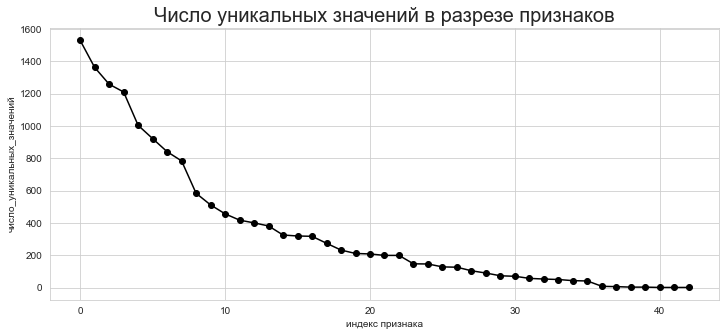

In [7]:
df_eda['число_уникальных_значений'].plot(marker = 'o', figsize = (12, 5), color = 'black')
plt.title('Число уникальных значений в разрезе признаков', fontsize = 20)
plt.xlabel('индекс признака')
plt.ylabel('число_уникальных_значений')
plt.show()

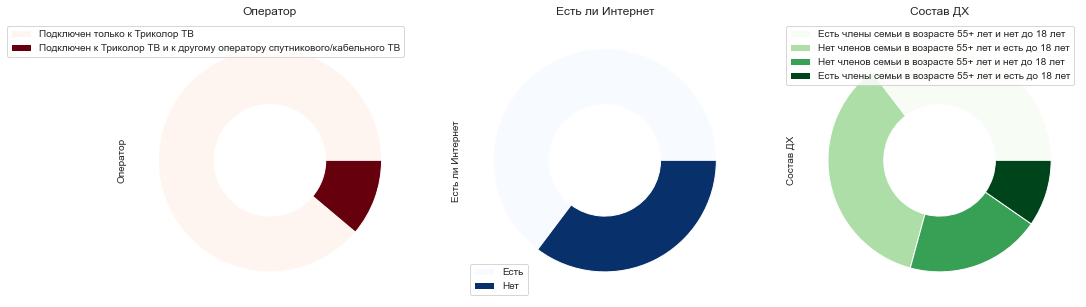

In [8]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (17, 9))
cmaps = ['Reds', 'Blues', 'Greens']
for i, col in enumerate(target_columns):
    shares = df_train[col].value_counts(normalize = True)
    shares.plot(kind = 'pie', ax = axes[i], labels =None, colormap=cmaps[i], wedgeprops=dict(width=0.5))
    axes[i].legend(shares.index)    
    axes[i].set_title(col)

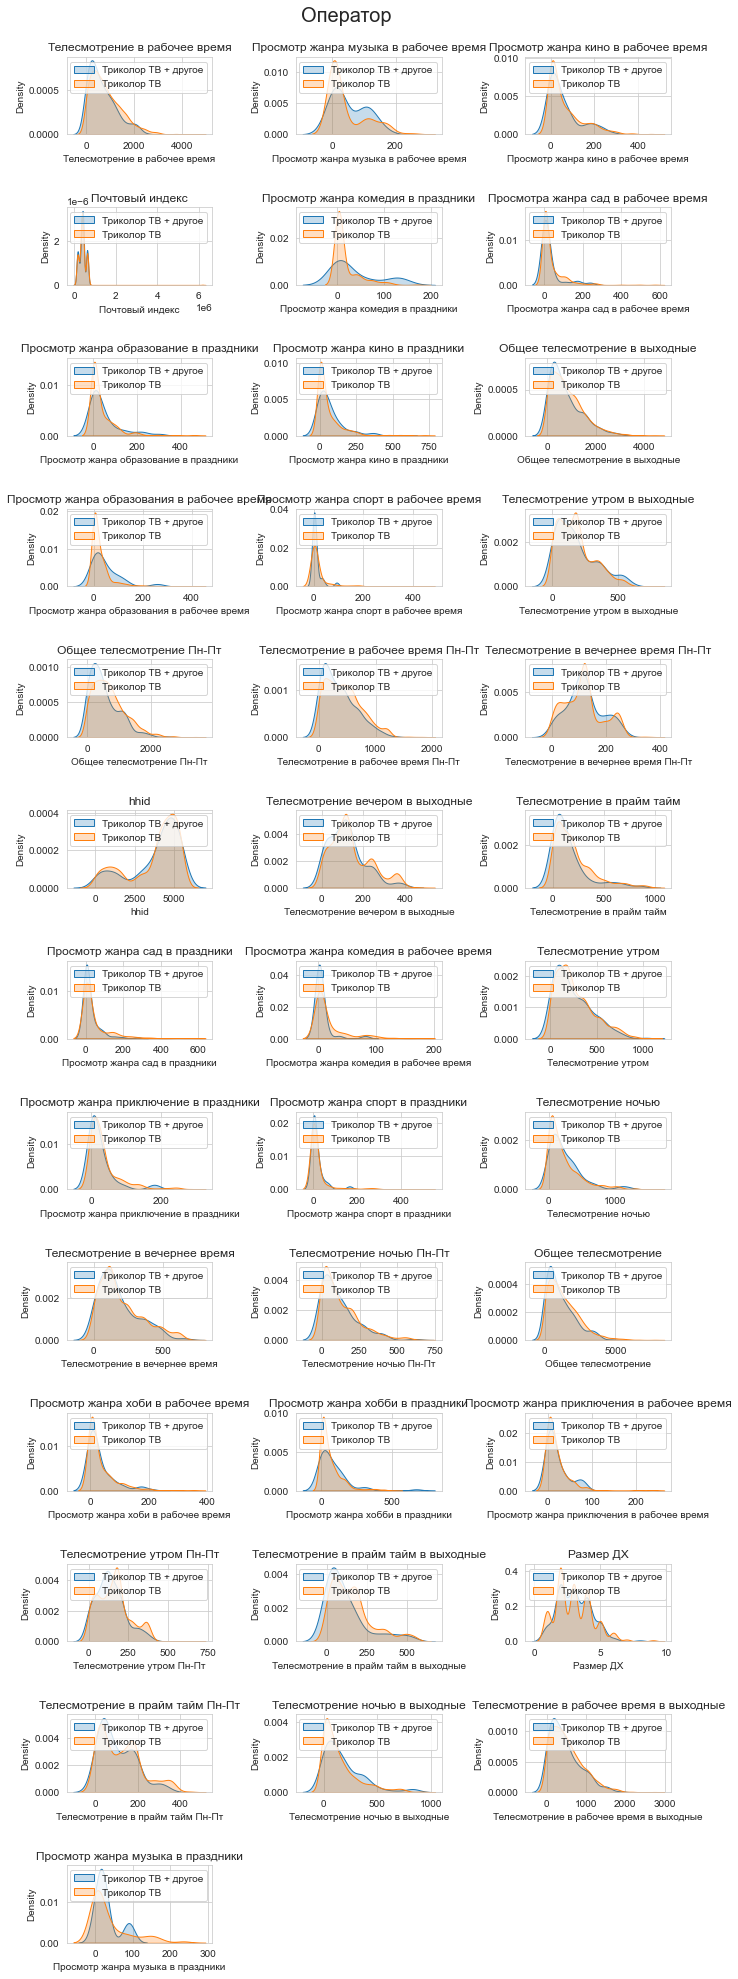

-------------------------------------------------------------------------------------------------------


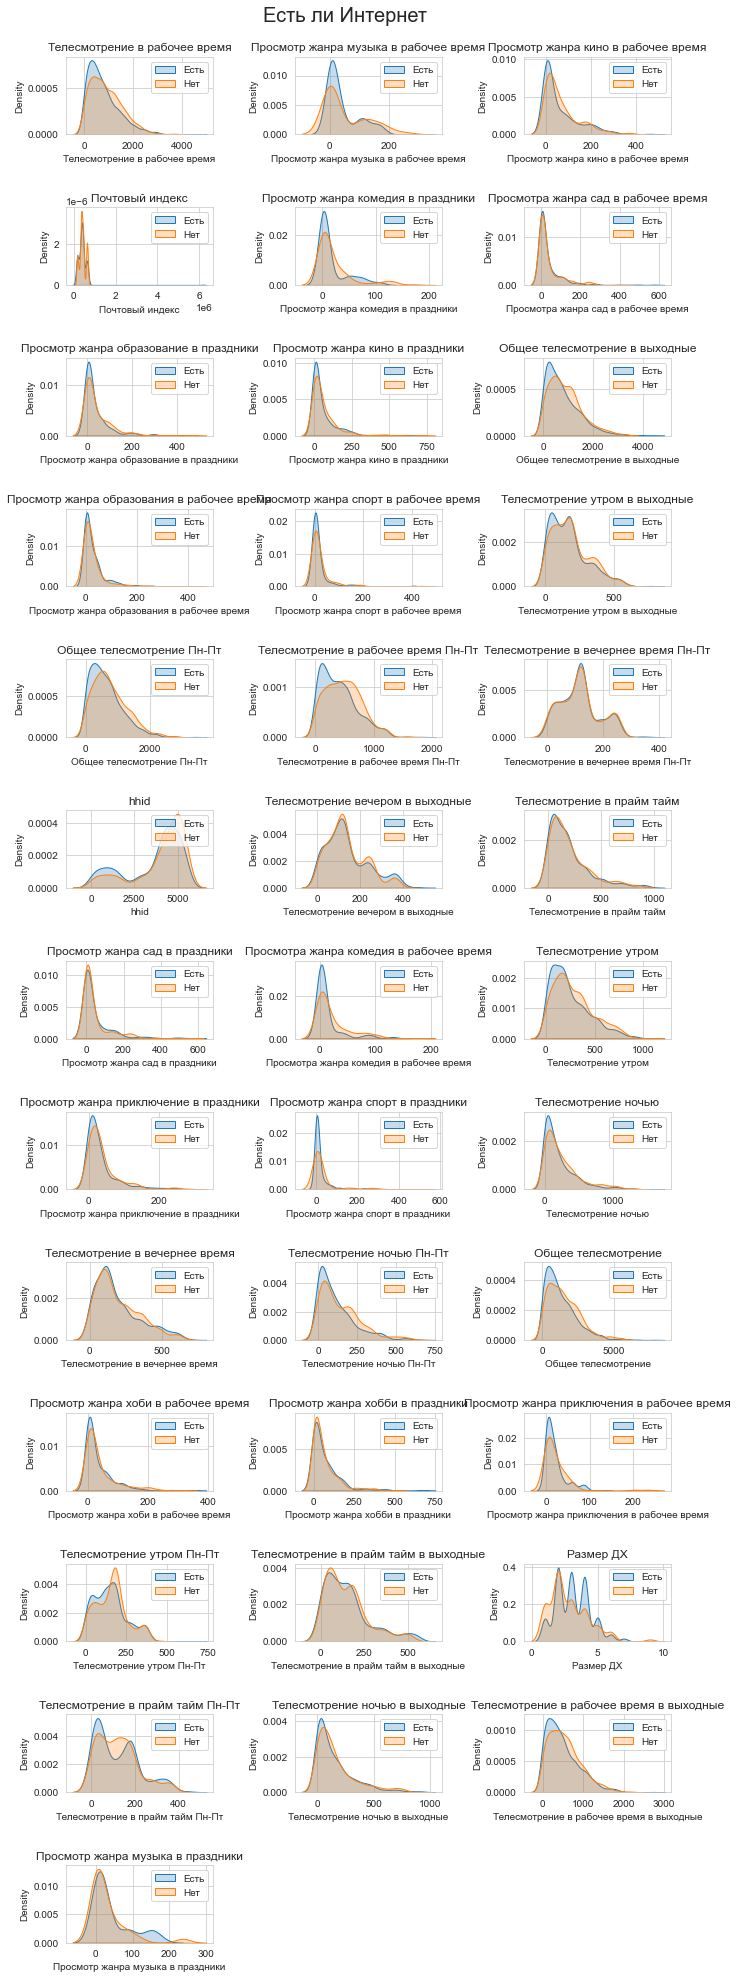

-------------------------------------------------------------------------------------------------------


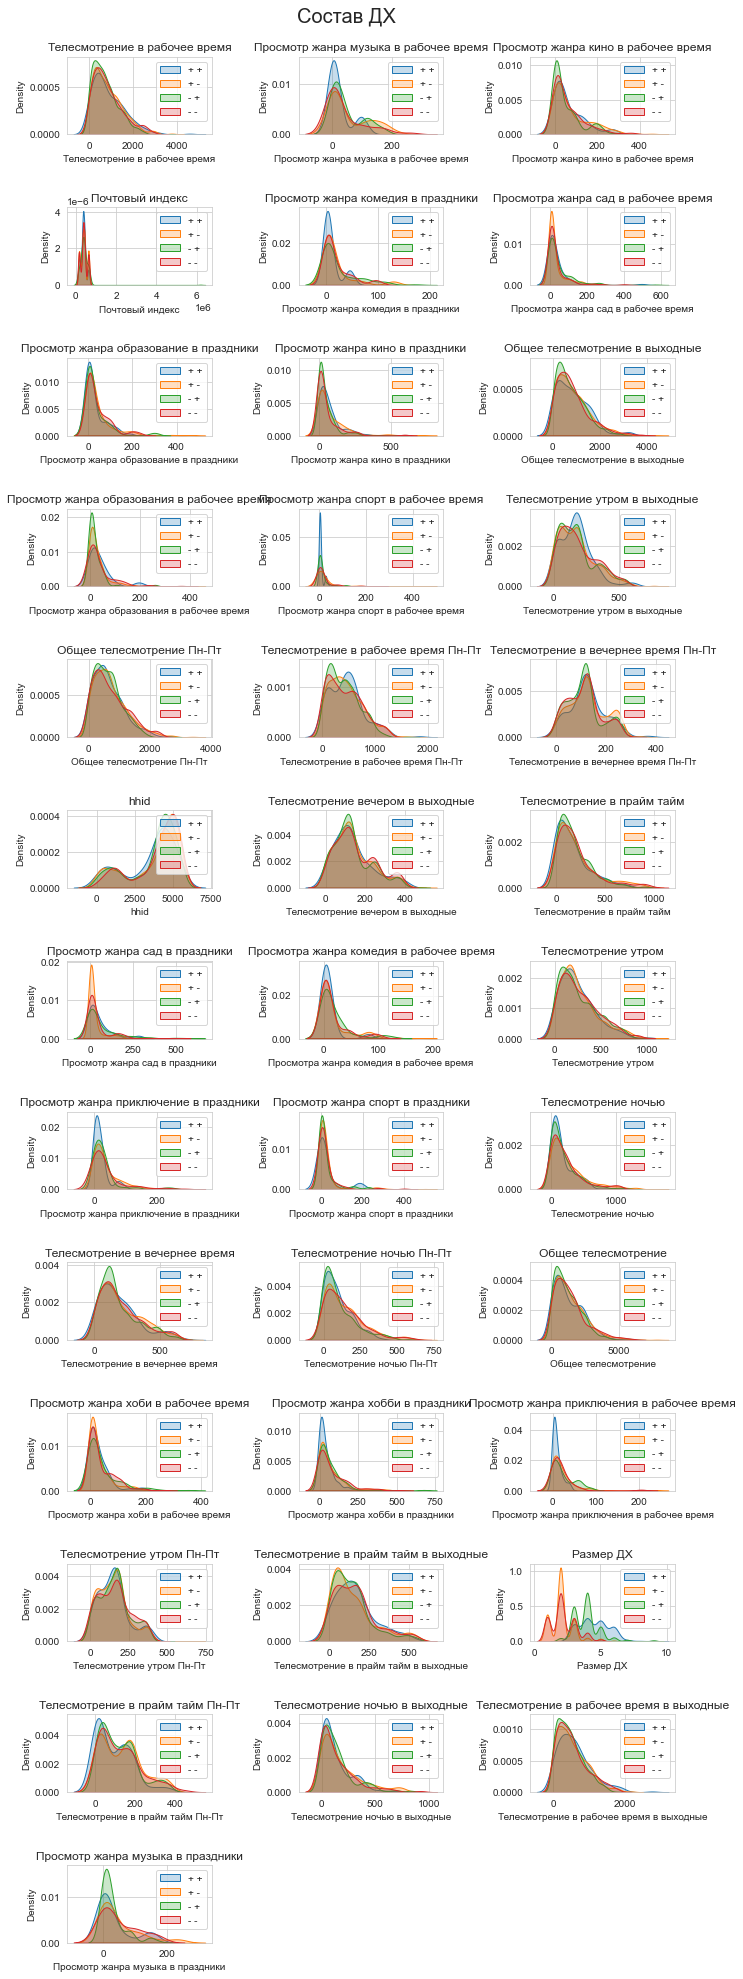

-------------------------------------------------------------------------------------------------------


In [9]:
# проходим по целевым признакам
for BY in target_columns:
    f = plt.figure(figsize = (10, 30))
    plt.suptitle(BY, fontsize = 20)
    
    # проходим по остальным признакам
    for i, c in enumerate(df_train.select_dtypes('number').columns):
        plt.subplot(14, 3, i+1)
        bys = []
        
        # группироуем по целевому, выбираем текущий признак
        # рисуем плотность
        for by, subdf in df_train.groupby(BY):
            to_plot = subdf[c]
            sns.kdeplot(to_plot, shade = True) 
            plt.title(c)
            bys.append(by)
        if BY == 'Оператор':
            plt.legend(['Триколор ТВ + другое', 'Триколор ТВ'])
        elif BY == 'Есть ли Интернет':
            plt.legend(bys)
        else:
            plt.legend(['+ +', '+ -', '- +', '- -'])
    plt.subplots_adjust(hspace = .8, wspace = .3) 
    f.tight_layout(pad=3)
    plt.show()
    print('-------------------------------------------------------------------------------------------------------')

In [10]:
features = ['hhid', 'Общее телесмотрение', 'Телесмотрение ночью',
       'Телесмотрение утром', 'Телесмотрение в рабочее время',
       'Телесмотрение в вечернее время', 'Телесмотрение в прайм тайм',
       'Общее телесмотрение Пн-Пт', 'Телесмотрение ночью Пн-Пт',
       'Телесмотрение утром Пн-Пт', 'Телесмотрение в рабочее время Пн-Пт',
       'Телесмотрение в вечернее время Пн-Пт',
       'Телесмотрение в прайм тайм Пн-Пт', 'Общее телесмотрение в выходные',
       'Телесмотрение ночью в выходные', 'Телесмотрение утром в выходные',
       'Телесмотрение в рабочее время в выходные',
       'Телесмотрение вечером в выходные',
       'Телесмотрение в прайм тайм в выходные',
       'Просмотр жанра кино в рабочее время',
       'Просмотр жанра кино в праздники',
       'Просмотр жанра приключения в рабочее время',
       'Просмотр жанра приключение в праздники',
       'Просмотра жанра сад в рабочее время', 'Просмотр жанра сад в праздники',
       'Просмотра жанра комедия в рабочее время',
       'Просмотр жанра комедия в праздники',
       'Просмотр жанра хоби в рабочее время',
       'Просмотр жанра хобби в праздники',
       'Просмотр жанра спорт в рабочее время',
       'Просмотр жанра спорт в праздники',
       'Просмотр жанра музыка в рабочее время',
       'Просмотр жанра музыка в праздники',
       'Просмотр жанра образования в рабочее время',
       'Просмотр жанра образование в праздники', 'Размер ДХ',
       'Почтовый индекс']
targets = ['Оператор', 'Есть ли Интернет', 'Состав ДХ']

In [11]:
ALPHA = .05
min_samples_leaf = 10
L_ttests = []
# проходим по целевым
for BY in tqdm_notebook(targets):
    s = df_train[BY]
    
    # уникальные значения целевого признака
    s_uniques = s.unique()
    
    # срезаем все комбинации значений целевого признака
    for i in tqdm_notebook(range(len(s_uniques))):
        for j in range(i+1, len(s_uniques)):
            v1, v2 = s_uniques[i], s_uniques[j]
            subdf1 = df_train[s==v1][features]
            subdf2 = df_train[s==v2][features]
            
            # выбираем текущий признак, сравниваем средние в 2-ух группах с помощью бутстрепа и теста Стьюдента
            for col in tqdm_notebook(subdf1.columns):
                ser1 = subdf1[col]
                ser2 = subdf2[col]
                if (len(ser1)>=min_samples_leaf) & (len(ser2)>=min_samples_leaf):
                    bt_means1 = [ser1.sample(5, random_state = i).mean() for i in range(1000)]
                    bt_means2 = [ser2.sample(5, random_state = i).mean() for i in range(1000)]

                    pvalue = stats.ttest_ind(bt_means1, bt_means2)[1]
                    L_ttests.append((BY, v1, v2, col, pvalue))
df_ttests = pd.DataFrame(L_ttests, columns = ['целевой_признак', 'значение1', 'значение2', 'признак', 'p-value'])

#### Результаты теста Стьюдента для среднего значения признака в двух группах(целевой_признак==значение1,целевой_признак==значение2) в порядке убывания pvalue

In [12]:
df_ttests['средние_одинаковые'] = df_ttests['p-value']<=ALPHA
df_ttests_pval = df_ttests[~df_ttests['средние_одинаковые']]\
                        .reset_index(drop = True)\
                        .sort_values('p-value', ascending = False)\
                        .drop('p-value', 1)


In [13]:
df_ttests_pval

,целевой_признак,значение1,значение2,признак,средние_одинаковые
145,Состав ДХ,Есть члены семьи в возрасте 55+ лет и нет до 1...,Нет членов семьи в возрасте 55+ лет и нет до 1...,Общее телесмотрение,False
157,Состав ДХ,Есть члены семьи в возрасте 55+ лет и нет до 1...,Нет членов семьи в возрасте 55+ лет и нет до 1...,Общее телесмотрение в выходные,False
160,Состав ДХ,Есть члены семьи в возрасте 55+ лет и нет до 1...,Нет членов семьи в возрасте 55+ лет и нет до 1...,Телесмотрение в рабочее время в выходные,False
151,Состав ДХ,Есть члены семьи в возрасте 55+ лет и нет до 1...,Нет членов семьи в возрасте 55+ лет и нет до 1...,Общее телесмотрение Пн-Пт,False
148,Состав ДХ,Есть члены семьи в возрасте 55+ лет и нет до 1...,Нет членов семьи в возрасте 55+ лет и нет до 1...,Телесмотрение в рабочее время,False
...,...,...,...,...,...
237,Состав ДХ,Нет членов семьи в возрасте 55+ лет и нет до 1...,Есть члены семьи в возрасте 55+ лет и есть до ...,Просмотр жанра спорт в праздники,False
238,Состав ДХ,Нет членов семьи в возрасте 55+ лет и нет до 1...,Есть члены семьи в возрасте 55+ лет и есть до ...,Просмотр жанра музыка в рабочее время,False
239,Состав ДХ,Нет членов семьи в возрасте 55+ лет и нет до 1...,Есть члены семьи в возрасте 55+ лет и есть до ...,Просмотр жанра музыка в праздники,False
240,Состав ДХ,Нет членов семьи в возрасте 55+ лет и нет до 1...,Есть члены семьи в возрасте 55+ лет и есть до ...,Просмотр жанра образования в рабочее время,False


In [14]:
df_ttests_pval['признак'].value_counts().to_frame('кол-во значимых различий')

,кол-во значимых различий
Просмотр жанра музыка в праздники,8
Просмотр жанра хоби в рабочее время,8
Просмотр жанра приключение в праздники,8
Просмотр жанра образование в праздники,8
Просмотр жанра спорт в праздники,8
Просмотр жанра музыка в рабочее время,8
Телесмотрение в прайм тайм,8
Просмотр жанра комедия в праздники,8
Просмотра жанра комедия в рабочее время,8
Просмотр жанра кино в рабочее время,8


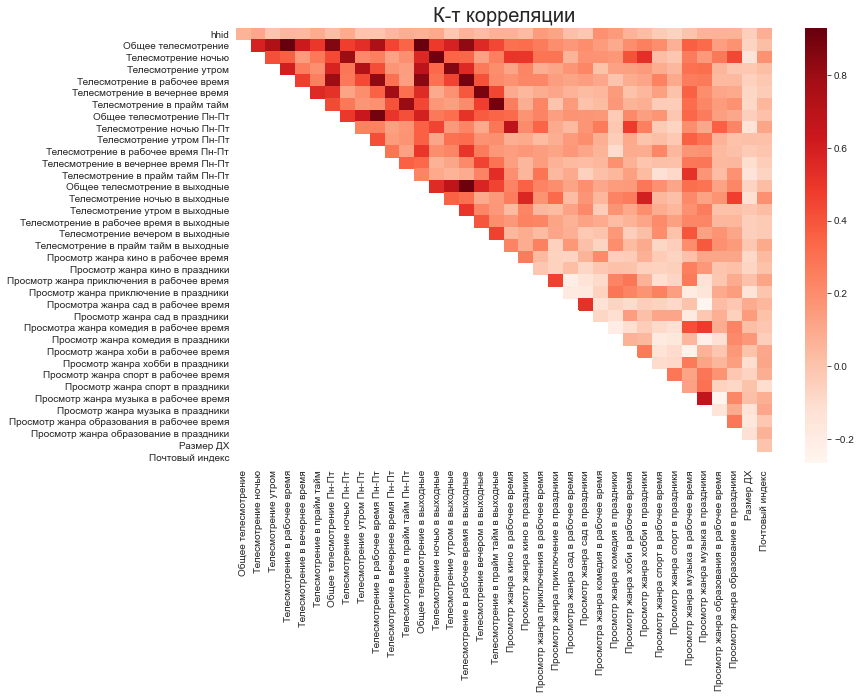

In [15]:
df_corr = df_train[features].corr()
df_corr_triu = df_corr.where(np.triu(np.ones_like(df_corr).astype(np.bool),k=1))

plt.figure(figsize=(12, 8))

sns.heatmap(df_corr_triu.loc[:, ~df_corr_triu.isna().all()], cmap='Reds')
plt.title('К-т корреляции',fontsize= 20)
plt.show()

### 2. Моделирование

#### 2.1. подготовка признаков

In [16]:
num_features = ['hhid', 'Общее телесмотрение', 'Телесмотрение ночью',
       'Телесмотрение утром', 'Телесмотрение в рабочее время',
       'Телесмотрение в вечернее время', 'Телесмотрение в прайм тайм',
       'Общее телесмотрение Пн-Пт', 'Телесмотрение ночью Пн-Пт',
       'Телесмотрение утром Пн-Пт', 'Телесмотрение в рабочее время Пн-Пт',
       'Телесмотрение в вечернее время Пн-Пт',
       'Телесмотрение в прайм тайм Пн-Пт', 'Общее телесмотрение в выходные',
       'Телесмотрение ночью в выходные', 'Телесмотрение утром в выходные',
       'Телесмотрение в рабочее время в выходные',
       'Телесмотрение вечером в выходные',
       'Телесмотрение в прайм тайм в выходные',
       'Просмотр жанра кино в рабочее время',
       'Просмотр жанра кино в праздники',
       'Просмотр жанра приключения в рабочее время',
       'Просмотр жанра приключение в праздники',
       'Просмотра жанра сад в рабочее время', 'Просмотр жанра сад в праздники',
       'Просмотра жанра комедия в рабочее время',
       'Просмотр жанра комедия в праздники',
       'Просмотр жанра хоби в рабочее время',
       'Просмотр жанра хобби в праздники',
       'Просмотр жанра спорт в рабочее время',
       'Просмотр жанра спорт в праздники',
       'Просмотр жанра музыка в рабочее время',
       'Просмотр жанра музыка в праздники',
       'Просмотр жанра образования в рабочее время',
       'Просмотр жанра образование в праздники', 'Размер ДХ',
       'Почтовый индекс']
obj_features = ['Тип ресивера', 'ФО', 'Тип нас.пункта']
targets = ['Оператор', 'Есть ли Интернет', 'Состав ДХ']

columns_obshee = ['Общее телесмотрение', 'Общее телесмотрение Пн-Пт',
                  'Общее телесмотрение в выходные']
columns_ne_obshee = ['Телесмотрение ночью', 'Телесмотрение утром',
                     'Телесмотрение в рабочее время', 'Телесмотрение в вечернее время',
                     'Телесмотрение в прайм тайм', 'Телесмотрение ночью Пн-Пт',
                     'Телесмотрение утром Пн-Пт', 'Телесмотрение в рабочее время Пн-Пт',
                     'Телесмотрение в вечернее время Пн-Пт',
                     'Телесмотрение в прайм тайм Пн-Пт', 'Телесмотрение ночью в выходные',
                     'Телесмотрение утром в выходные',
                     'Телесмотрение в рабочее время в выходные',
                     'Телесмотрение вечером в выходные',
                     'Телесмотрение в прайм тайм в выходные',
                     'Просмотр жанра кино в рабочее время',
                     'Просмотр жанра кино в праздники',
                     'Просмотр жанра приключения в рабочее время',
                     'Просмотр жанра приключение в праздники',
                     'Просмотра жанра сад в рабочее время', 'Просмотр жанра сад в праздники',
                     'Просмотра жанра комедия в рабочее время',
                     'Просмотр жанра комедия в праздники',
                     'Просмотр жанра хоби в рабочее время',
                     'Просмотр жанра хобби в праздники',
                     'Просмотр жанра спорт в рабочее время',
                     'Просмотр жанра спорт в праздники',
                     'Просмотр жанра музыка в рабочее время',
                     'Просмотр жанра музыка в праздники',
                     'Просмотр жанра образования в рабочее время',
                     'Просмотр жанра образование в праздники']

#### 2.2. константы

In [17]:
SEED = 13
N_FOLDS = 10
HO_SIZE = .15
EARLY_STOPPING=100
SKF = StratifiedKFold(N_FOLDS, shuffle = True, random_state = SEED)
tree_grid = {'max_depth':np.arange(2, 21), 'min_samples_split':[2, 5, 10]}
knn_grid = {'n_neighbors':np.arange(2, 21)}
# # модели
D_MODELS = {'Lightgbm':LGBMClassifier(n_jobs=-1, random_state = SEED, n_estimators=100),
            'RandomForest':RandomForestClassifier(n_jobs=-1, random_state = SEED, n_estimators=100),\
            'ExtraTrees':ExtraTreesClassifier(n_jobs=-1, random_state = SEED, n_estimators=100),\
            'DecisionTree':DecisionTreeClassifier(),\
            'ExtraTree':ExtraTreeClassifier()}
# D_MODELS = { 'RandomForest':RandomForestClassifier(n_jobs=-1, random_state = SEED, n_estimators=100)}
kappa_scorer = make_scorer(cohen_kappa_score)
SCORER = kappa_scorer

#### 2.3. выполнение пайплайнов

In [22]:
%%time

D_cv_results = {}
D_features = {}
D_predictions= {}
for KEY in tqdm_notebook(targets):
    
    # подготовка данных
    _X_tr, _X_ho, _y_tr, _y_ho, _X_te = prepare_data(df_train, df_test, target_col=KEY)
    # сравнение валидации
    cvAB = pd.DataFrame()

    # выполнение пайплайнов
    for NAME, MODEL in tqdm_notebook(D_MODELS.items()):

        # пайплайн:подготовка+мультиколлинеарность+последовательный отбор признаков
        ppl = make_pipeline(MinMaxScaler(),\
                            SimpleImputer(strategy='constant', fill_value=-1),
                            SklearnHelperVIF(treshold=10), 
                            SklearnHelperFeatureSelector(model=MODEL,\
                                                         cv=SKF,\
                                                         scoring=SCORER,\
                                                         show_progress = True))

        ppl.fit(_X_tr, _y_tr)
        _X_sel_tr = ppl.transform(_X_tr)

        # рекурсивный отбор признаков
        rfe_selector = RFECV(MODEL, cv=SKF, scoring = SCORER, verbose =1)
        rfe_selector.fit(_X_sel_tr, _y_tr)

        # финальные признаки
        _x_tr = rfe_selector.transform(_X_sel_tr)
        _x_ho = rfe_selector.transform(ppl.transform(_X_ho))
        _x_te = rfe_selector.transform(ppl.transform(_X_te))
        
        # коллекционируем признаки
        if KEY not in list(D_features.keys()):            
            D_features[KEY] = {}
        if KEY not in list(D_predictions.keys()):            
            D_predictions[KEY] = {}
        D_features[KEY][NAME] = {'tr':_x_tr, 'ho':_x_ho, 'te':_x_te}
        
        # оптимизация гиперпараметров
        if NAME in ('DecisionTree', 'ExtraTree'):
            gs =GridSearchCV(MODEL, param_grid = tree_grid, cv = SKF, scoring = SCORER, verbose=1, n_jobs=-1)
            gs.fit(_x_tr,_y_tr)
            cv_score= gs.best_score_ 
            ho_score =cohen_kappa_score(_y_ho, gs.best_estimator_.predict(_x_ho))
            D_predictions[KEY][NAME] = gs.best_estimator_.predict(_x_te)
        elif NAME in ('RandomForest', 'ExtraTrees'):
            gs =GridSearchCV(MODEL, param_grid = tree_grid, cv = SKF, scoring = SCORER, verbose=1, n_jobs=-1)
            gs.fit(_x_tr,_y_tr)
            gs2 =GridSearchCV(gs.best_estimator_, param_grid = {'n_estimators':[1000]},\
                              cv = SKF, scoring = SCORER, verbose=1, n_jobs=-1)
            gs2.fit(_x_tr,_y_tr)            
            cv_score= gs2.best_score_            
            ho_score =cohen_kappa_score(_y_ho, gs2.best_estimator_.predict(_x_ho))
            D_predictions[KEY][NAME] = gs2.best_estimator_.predict(_x_te)
        elif NAME == 'KNN':
            gs =GridSearchCV(MODEL, param_grid = knn_grid, cv = SKF, scoring = SCORER, verbose=1, n_jobs=-1)
            gs.fit(_x_tr,_y_tr)
            cv_score= gs.best_score_
            ho_score =cohen_kappa_score(_y_ho, gs.best_estimator_.predict(_x_ho))
            D_predictions[KEY][NAME] = gs.best_estimator_.predict(_x_te)
        elif NAME == 'Logit':
            gs =GridSearchCV(MODEL, param_grid = {'C':np.logpsace(-2, 2, 100)},\
                             cv = SKF, scoring = SCORER, verbose=1, n_jobs=-1)
            gs.fit(_x_tr,_y_tr)
            cv_score= gs.best_score_
            ho_score =cohen_kappa_score(_y_ho, gs.best_estimator_.predict(_x_ho))
            D_predictions[KEY][NAME] = gs.best_estimator_.predict(_x_te)
        else:
            gs =GridSearchCV(MODEL,\
                                 param_grid = {'n_estimators':[20],\
                                               'random_state':[SEED],\
                                               'max_depth':np.arange(2, 31),\
                                               'num_leaves':[2, 4, 8, 12, 16, 32, 64, 128, 256, 512],\
                                               'min_child_samples':[20, 30, 50]},\
                                cv = SKF, scoring = SCORER, verbose = 1, n_jobs=-1)
            gs.fit(_x_tr, _y_tr)
            bp = gs.best_params_

            gs2 =GridSearchCV(gs.best_estimator_,\
                                 param_grid = {'n_estimators':[20],\
                                               'random_state':[SEED],\
                                               'subsample':np.linspace(.1, 1, 10), 'colsample_bytree':np.linspace(.1, 1, 10)},\
                                cv = SKF, scoring = SCORER, verbose = 1, n_jobs=-1)
            gs2.fit(_x_tr, _y_tr)
            bp.update(gs2.best_params_)

            gs3 =GridSearchCV(gs2.best_estimator_,\
                                 param_grid = {'n_estimators':[100],\
                                               'random_state':[SEED],\
                                               'learning_rate':np.linspace(.005, .1, 50)},\
                                cv = SKF, scoring = SCORER, verbose = 1, n_jobs=-1)
            gs3.fit(_x_tr, _y_tr)
            bp.update(gs3.best_params_)
            gs.fit(_x_tr, _y_tr)

            cv_score= gs.best_score_
            ho_score =cohen_kappa_score(_y_ho, gs.best_estimator_.predict(_x_ho))  
            D_predictions[KEY][NAME] = gs.best_estimator_.predict(_x_te)
        cvAB.loc[NAME, 'cv'] = cv_score
        cvAB.loc[NAME, 'ho'] = ho_score
    
    # коллекционируем результаты
    D_cv_results[KEY] = cvAB
    
# сохраняем результаты    
with open('D_cv_results.pickle','wb') as f:
    pickle.dump(D_cv_results, f)
with open('D_features.pickle','wb') as f:
    pickle.dump(D_features, f)  
with open('D_predictions.pickle','wb') as f:
    pickle.dump(D_predictions, f)

new best score = 0.5709084112
new best score = 0.6595612652
new best score = 0.6946012217
new best score = 0.7047010675
new best score = 0.7352567224




Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 8700 out of 8700 | elapsed:   24.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 485 out of 500 | elapsed:   14.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.2s finished


Fitting 10 folds for each of 870 candidates, totalling 8700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 8700 out of 8700 | elapsed:   23.2s finished


new best score = 0.8568715191
new best score = 0.8641440472
new best score = 0.8647934590
new best score = 0.8673743120




Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:   29.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.7s finished


new best score = 0.8431175555
new best score = 0.8499751348
new best score = 0.8508972239




Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 555 out of 570 | elapsed:   20.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


new best score = 0.8233958957




Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting 10 folds for each of 57 candidates, totalling 570 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:    0.5s finished


new best score = 0.8188047370
new best score = 0.8246326778




Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting 10 folds for each of 57 candidates, totalling 570 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:    0.3s finished


new best score = 0.4945520780
new best score = 0.5871835439
new best score = 0.6011141784
new best score = 0.6031358145
new best score = 0.6205573236




Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 8700 out of 8700 | elapsed:   23.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.2s finished


Fitting 10 folds for each of 870 candidates, totalling 8700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 8700 out of 8700 | elapsed:   22.5s finished


new best score = 0.8241818068
new best score = 0.8249628585




Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting 10 folds for each of 57 candidates, totalling 570 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:   29.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.5s finished


new best score = 0.8171913825
new best score = 0.8230164126



new best score = 0.8241430740
new best score = 0.8345070726




Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.7s finished


new best score = 0.8121160304
new best score = 0.8165098866
new best score = 0.8233906624




Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:    0.6s finished


new best score = 0.8277605403




Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting estimator with 2 features.
Fitting 10 folds for each of 57 candidates, totalling 570 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:    0.3s finished


new best score = 0.5867917449
new best score = 0.7597445437
new best score = 0.7749614464
new best score = 0.7785743523
new best score = 0.7948191888




Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 6000 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 8700 out of 8700 | elapsed:  1.2min finished


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   15.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.0min finished


Fitting 10 folds for each of 870 candidates, totalling 8700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 6000 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 8700 out of 8700 | elapsed:  1.2min finished


new best score = 0.8286720361
new best score = 0.8594161595
new best score = 0.8635760114




Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:   32.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.6s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.9s finished


new best score = 0.8267133127
new best score = 0.8590303629
new best score = 0.8600974309
new best score = 0.8611796523
new best score = 0.8684004129




Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:   23.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.3s finished


new best score = 0.8281415010
new best score = 0.8493832409




Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting 10 folds for each of 57 candidates, totalling 570 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:    0.4s finished


new best score = 0.8213467540
new best score = 0.8453092288
new best score = 0.8551539458




Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 4 features.
Fitting estimator w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s




Wall time: 16min


[Parallel(n_jobs=-1)]: Done 570 out of 570 | elapsed:    0.3s finished


In [28]:
D_cv_results['Оператор'].sort_values('ho', ascending = False)

,cv,ho
RandomForest,0.866952,0.900637
ExtraTrees,0.854350,0.900637
ExtraTree,0.816447,0.842514
DecisionTree,0.525604,0.445573
Lightgbm,0.427160,0.336899


In [29]:
D_cv_results['Есть ли Интернет'].sort_values('ho', ascending = False)

,cv,ho
RandomForest,0.825643,0.839524
ExtraTrees,0.822345,0.808716
DecisionTree,0.791408,0.805978
ExtraTree,0.771205,0.629513
Lightgbm,0.482219,0.497058


In [30]:
D_cv_results['Состав ДХ'].sort_values('ho', ascending = False)

,cv,ho
ExtraTrees,0.868384,0.909166
RandomForest,0.857406,0.897503
DecisionTree,0.839658,0.885843
ExtraTree,0.791905,0.799321
Lightgbm,0.677342,0.683258


In [26]:
sample_subm = pd.read_csv('sampleSubmission.csv')

In [ ]:
`